In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
# torch: The main PyTorch package
# torch.nn: Contains all of the building blocks for neural networks
# torch.optim: Package implementing various optimization algorithms
# DataLoader: Helps to load data in batches
# datasets: Contains standard datasets, including MNIST
# ToTensor: Converts PIL images or numpy arrays to PyTorch tensors

import pandas as pd
from PIL import Image
import os
from pathlib import Path


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# os.environ['CUDA_MODULE_LOADING'] = 'LAZY'

In [ ]:
from google.colab import files
files.upload()  # Upload the kaggle.json file

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c isic-2024-challenge


In [ ]:
!unzip isic-2024-challenge.zip -d isic-2024-challenge


In [4]:

!ls /content/isic-2024-challenge/

sample_submission.csv  test-metadata.csv  train-image.hdf5
test-image.hdf5        train-image	  train-metadata.csv


In [5]:
train_metadata_df = pd.read_csv('/content/isic-2024-challenge/train-metadata.csv')
train_metadata_df.head()

<ipython-input-5-078628bad27e>:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_metadata_df = pd.read_csv('/content/isic-2024-challenge/train-metadata.csv')


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [6]:
image_files = os.listdir('/content/isic-2024-challenge/train-image/image')
print(image_files[:5])

['ISIC_0275709.jpg', 'ISIC_2274996.jpg', 'ISIC_0750851.jpg', 'ISIC_4479259.jpg', 'ISIC_3607667.jpg']


NameError: name 'pos_img_files' is not defined

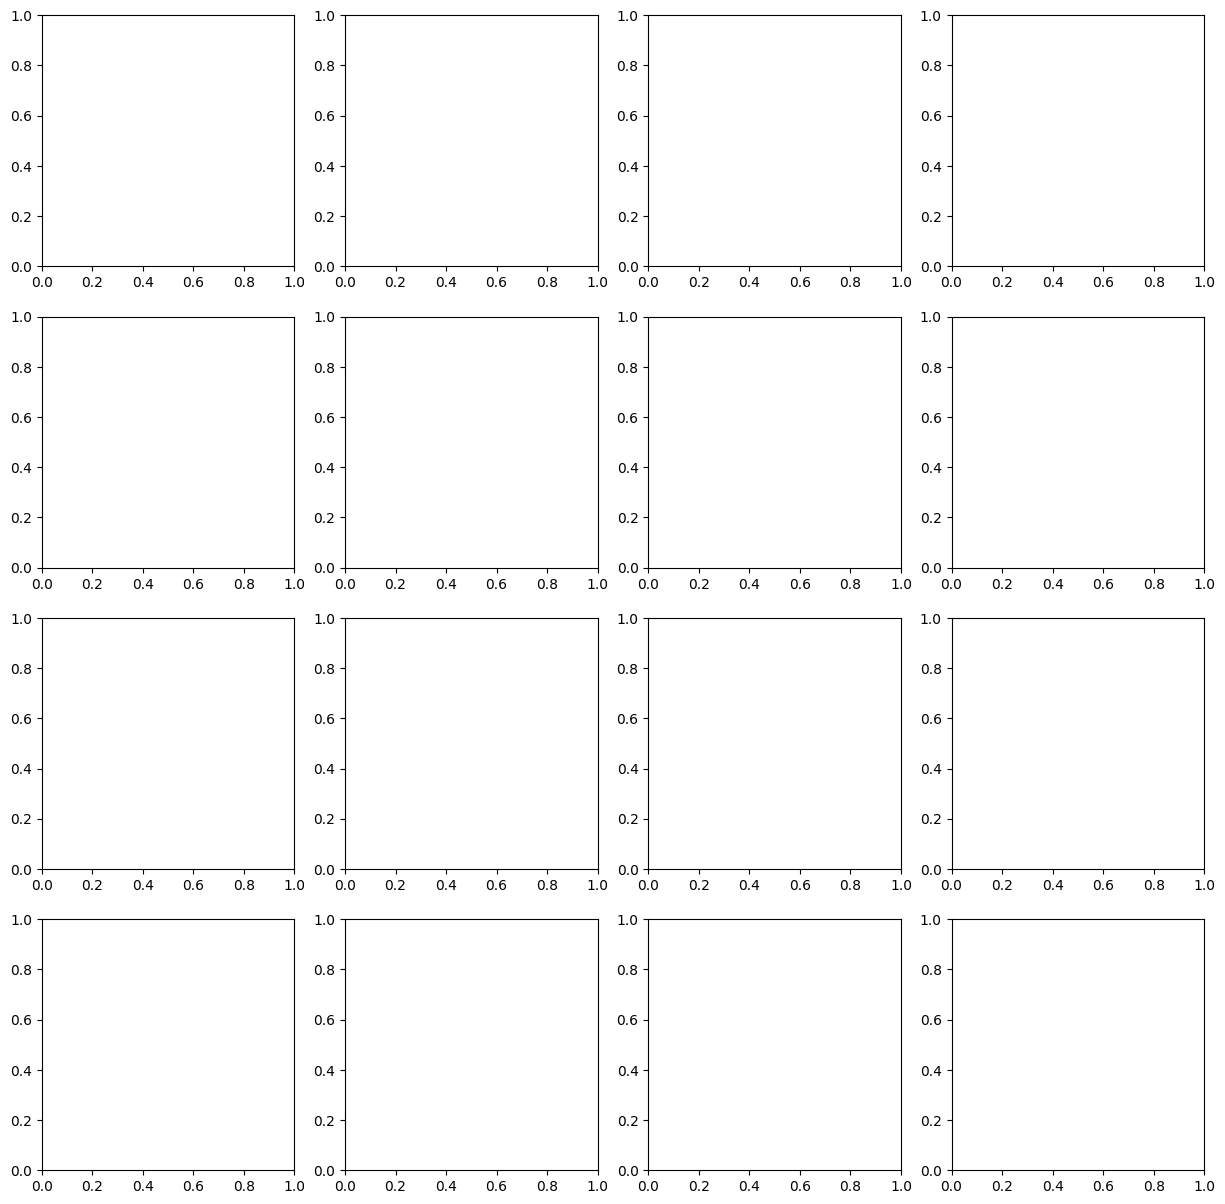

In [7]:
import os
from PIL import Image
import matplotlib.pyplot as plt

path = "/content/isic-2024-challenge"

# Example: Load and display images
fig, axs = plt.subplots(4, 4, figsize=(15, 15))

for ax, image_file, target in zip(axs.flatten(), pos_img_files + neg_img_files, [1] * 8 + [0] * 8):
    img_path = os.path.join(path, "train-image/image", f"{image_file}.jpg")
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis("off")

plt.show()


In [7]:
img_path = Path("/content/isic-2024-challenge/train-image/image")

In [8]:
train_metadata_df['img_path'] = train_metadata_df['isic_id'].apply(lambda x: img_path / f"{x}.jpg")
train_metadata_df.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,img_path
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282,/content/isic-2024-challenge/train-image/image...
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455,/content/isic-2024-challenge/train-image/image...
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040,/content/isic-2024-challenge/train-image/image...
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998,/content/isic-2024-challenge/train-image/image...
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510,/content/isic-2024-challenge/train-image/image...


In [9]:
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.dataframe.iloc[idx]['img_path']
        image = Image.open(img_path)

        # Apply transformations to the image
        if self.transform:
            image = self.transform(image)

        # Get the label (assuming it's in a column named 'target')
        label = torch.tensor(self.dataframe.iloc[idx]['target'], dtype=torch.float32)

        return image, label


In [10]:
from torchvision import transforms

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet standards
])

In [28]:
# Instantiate the dataset
dataset = ImageDataset(train_metadata_df, transform=transform)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=32, num_workers=1, shuffle=True)

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 1)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x


In [34]:
import torch.optim as optim

# Initialize the model, criterion, and optimizer
model = SimpleCNN()
model.to(device)
criterion = nn.BCELoss(weight = torch.tensor([320528/319]).to(device))  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(dataloader):
        # Zero the parameter gradients
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1))  # Ensure labels match output dimensions

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(dataloader)}, Loss: {loss.item()}")


Epoch 1/1, Batch 0/12534, Loss: 697.0859375, output: tensor([[0.4996],
        [0.4988],
        [0.4969],
        [0.5031],
        [0.4987],
        [0.5029],
        [0.4948],
        [0.5052],
        [0.5009],
        [0.4961],
        [0.4952],
        [0.5034],
        [0.4962],
        [0.5054],
        [0.4970],
        [0.4958],
        [0.4995],
        [0.4991],
        [0.4982],
        [0.5029],
        [0.4983],
        [0.5038],
        [0.4975],
        [0.5018],
        [0.5021],
        [0.5030],
        [0.4989],
        [0.5014],
        [0.5039],
        [0.5051],
        [0.5012],
        [0.5031]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Epoch 1/1, Batch 1/12534, Loss: 0.07720766961574554, output: tensor([[3.9863e-04],
        [3.3979e-07],
        [1.0307e-05],
        [3.3869e-07],
        [8.6892e-09],
        [8.6182e-08],
        [1.0747e-06],
        [2.6430e-06],
        [1.0378e-07],
        [5.2035e-07],
        [3.8178e-04],
        [1.2357e-08],


KeyboardInterrupt: 

### Evaluation